## **Prompt Chaining**

START → create_outline → create_blog → get_score → END

In [7]:
from langgraph.graph import StateGraph, START, END
from langchain_ollama import ChatOllama
from typing import TypedDict
import re

In [8]:
# Initialize Ollama LLaMA model
model = ChatOllama(
    model="llama3.2:1b",  # llama3.2:1b, llama3.1:8b
    temperature=0.7
)


In [9]:
class BlogState(TypedDict):
    title: str
    outline: str
    content: str
    score: float


In [10]:
# ---------------- OUTLINE GENERATION ---------------- #

def create_outline(state: BlogState) -> BlogState:
    title = state["title"]

    prompt = (
        "You are a professional content strategist.\n"
        f"Generate a clear, well-structured blog outline for the topic:\n"
        f"\"{title}\"\n\n"
        "The outline should include headings and subheadings."
    )

    response = model.invoke(prompt)
    state["outline"] = response.content.strip()

    return state


# ---------------- BLOG GENERATION ---------------- #

def create_blog(state: BlogState) -> BlogState:
    title = state["title"]
    outline = state["outline"]

    prompt = (
        "You are an expert blog writer.\n"
        f"Write a detailed, high-quality blog based on the following information.\n\n"
        f"Title:\n{title}\n\n"
        f"Outline:\n{outline}\n\n"
        "Ensure the blog is engaging, informative, and well-structured."
    )

    response = model.invoke(prompt)
    state["content"] = response.content.strip()

    return state


# ---------------- BLOG SCORING ---------------- #

def get_score(state: BlogState) -> BlogState:
    outline = state["outline"]
    content = state["content"]

    prompt = (
        "You are a strict content evaluator.\n"
        "Evaluate the blog based on how well it follows the provided outline.\n"
        "Return the score strictly in this format: X.X/10\n\n"
        "Rules:\n"
        "- Return ONLY the score\n"
        "- No explanation, no extra text\n\n"
        f"Outline:\n{outline}\n\n"
        f"Blog Content:\n{content}\n\n"
        "Score:"
    )

    response = model.invoke(prompt)
    
    match = re.search(r"\d+(\.\d+)?/10", response.content)
    state["score"] = match.group() if match else ""

    return state



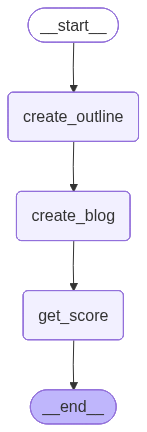

In [11]:
# Graph
graph = StateGraph(BlogState)

# Nodes
graph.add_node('create_outline', create_outline)
graph.add_node('create_blog', create_blog)
graph.add_node('get_score', get_score)

# Edge
graph.add_edge(START, 'create_outline')
graph.add_edge('create_outline', 'create_blog')
graph.add_edge('create_blog', 'get_score')
graph.add_edge('get_score', END)

workflow = graph.compile()
workflow


In [12]:
# Execute
initial_state = {'title': 'Rise of AI in India'}

final_state = workflow.invoke(initial_state)
final_state


{'title': 'Rise of AI in India',
 'outline': 'Here is a suggested outline for a blog post on "Rise of AI in India":\n\n**I. Introduction**\n\n* Title: "Harnessing the Power of Artificial Intelligence in India"\n* Subtitle: "A Growing Industry with Significant Economic Implications"\n* Brief overview of the increasing importance of artificial intelligence (AI) globally\n* Thesis statement: "India is poised to become a significant player in the AI market, driven by government initiatives, technological advancements, and growing demand for advanced technologies."\n\n**II. Government Initiatives and Policies**\n\n* Title: "Government Support for AI Development"\n* Subheading: "Fulfilling the Vision of a \'Digital India\'"\n* Overview of key government policies and programs aimed at promoting AI development in India\n* Examples:\n\t+ National Policy on Digital India (2015)\n\t+ Artificial Intelligence at Work Act (2019)\n\t+ Indian Institutes of Technology (IITs) AI research initiatives\n\n

In [15]:
final_state['content']


'**Harnessing the Power of Artificial Intelligence in India: A Rising Industry with Significant Economic Implications**\n\nAs the world becomes increasingly interconnected, artificial intelligence (AI) has emerged as a vital component of modern technology. In recent years, India has been at the forefront of AI adoption, driven by government initiatives, technological advancements, and growing demand for advanced technologies. In this blog post, we will delve into the rise of AI in India, exploring its government support, technological progress, industry trends, challenges, and concerns.\n\n**Government Support for AI Development**\n\nThe Indian government has recognized the vast potential of AI to drive economic growth and development. The National Policy on Digital India (2015) set a clear direction for promoting digital transformation across various sectors, including education, healthcare, finance, and e-commerce. Additionally, the Artificial Intelligence at Work Act (2019) aimed to

In [16]:
final_state['score']

'9/10'